(techniques:loops_static_se)=
# Loops in Static Symbolic Execution

In [1]:
import utils
from minipy import *
from semantics import *
from symbolic_interpreter import *
from transparent_function_execution import *

Loops are a standard obstacle in symbolic execution. The dynamic / concolic variants of SE use concrete inputs as guides, which ensures the termination of the analysis even in the presence of symbolic loop guards. In static SE, termination is easiest ensured by *bounded* unwinding (see {ref}`foundations:symbolic_interpreter`). However, this impedes the construction of an *exhaustive* symbolic execution procedure (see {ref}`foundations:correctness`), as generally some loop paths will not be covered if the number of loop executions is not bound by a constant.

The standard way to deal with unbounded loops in exhaustive symbolic execution are *loop invariants* {cite}`hoare-69`. Essentially, a loop invariant is an assertion satisfied by the loop after any number of iterations (i.e., the the assertion is *invariant* with respect to the number of completed loop iterations). Thus, we can abstract a loop by its invariant and continue symbolic execution.

To prove that a formula $\mathit{Inv}$ is indeed a loop invariant in the first place, we have to assert that

1. (*Initially Valid*) $\mathit{Inv}$ holds initially, that is, right before the *very first* loop iteration, and
2. (*Preserved*) if $\mathit{Inv}$ holds at the beginning of an *arbitrary* iteration, $\mathit{Inv}$ also holds right before the next iteration.

In rule-based symbolic execution systems, loop invariant-based reasoning is performed by loop invariant rules (see, e.g., {cite}`dannenberg.ernst-82` {cite}`ahrendt.beckert.ea-16`). Alternatively, we can encode the above two proof cases as well as the case where we assume the invariant and resume symbolic execution (the "Use Case") into the program. This approach, which is, for example, followed by the Boogie verifier {cite}`barnett.chang.ea-05`, requires two additional statement types: (1) *havoc statements* `havoc x` erase the currently assigned value for the variable `x` in the symbolic store, assigning it a fresh, symbolic value; and (2) *assume statements* `assume expr`, which add the boolean expression `expr` to the path condition.

Assuming these verification-only statements, we transform a loop as follows, where `Inv` is a loop invariant and `x_1` to `x_n` are the variables written in the loop body: A loop statement

```python
while guard:
    body
    
remaining_program
```

is transformed to

```python
assert Inv        # Initially Valid

havoc x_1
havoc x_2
havoc ...
havoc x_n
assume Inv

if guard:
    body
    assert Inv    # Preserved
    assume False

remaining_program # Use Case
```

The `assume False` after the "Preserved" assertion indicates that we reached a code path which does not exit the loop and preserves `Inv` (since the assertion before was satisfied). Assuming `False` leads to a symbolic state with unsatisfiable path condition, such that symbolic execution stops at that point.

Consider, for example, the following program computing the product of all integers in a tuple `t`:

```python
i = 0
result = 1
while i < len(t):
    elem = t[i]
    result = result * elem
    i = i + 1
    
return result
```

One loop invariant for this program is $\mathtt{i}\geq{}0\wedge\mathtt{i}\leq\mathtt{len(t)}\land\texttt{result % elem} = 0$, informally "`i` ranges between 0 (before the loop) and, inclusively, `len(t)` (after loop termination), and the current tuple element is a factor of `result`".

Let `Inv(i, t, result)` denote the invariant expression. Then, the product computation program is transformed to

```python
i = 0
result = 1
elem = 1 

assert Inv(i, t, elem, result)

havoc i
havoc elem
havoc result
assume Inv(i, t, elem, result)

if i < len(t):
    elem = t[i]
    result = result * elem
    i = i + 1
    assert Inv(i, t, elem, result)
    assume False

return result
```

## Loop Invariant Reasoning using Program Transformation

To enable this program transformation-based approach to loop invariant reasoning, we add `havoc` and `assume` statements to minipy and the symbolic interpreter. Since these statements work with symbolic expressions and manipulate path constraints, it does not make much sense to integrate them also in the concrete minipy interpreter.

We first extend the minipy grammar.

In [2]:
MINIPY_GRAMMAR["<simple_stmt>"].insert(3, "<havoc_stmt>")
MINIPY_GRAMMAR["<simple_stmt>"].insert(6, "<assume_stmt>")
MINIPY_GRAMMAR["<havoc_stmt>"] = ["havoc <NAME>"]
MINIPY_GRAMMAR["<assume_stmt>"] = ["assume <expression>"]

Next, we add AST node classes, extend the AST converter, and re-declare the `parse` function to use the new `ASTConverter` version.

In [3]:
class Havoc(ASTNode):
    def __init__(self, variable: str):
        super().__init__("havoc " + variable)
        self.variable = variable

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)

In [4]:
class Assume(ASTNode):
    def __init__(self, expression: 'Expression'):
        super().__init__("assume " + expression.code)
        self.expression = expression

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Assume(self.expression.transform(transformer)))

In [5]:
class ASTConverter(ASTConverter):
    def __init__(self):
        super().__init__()
        self.stmt_interpretations["<havoc_stmt>"] = self.transform_havoc_stmt
        self.stmt_interpretations["<assume_stmt>"] = self.transform_assume_stmt
        
    def transform_simple_stmt(self, stmt: ParseTree) -> ASTNode:
        return self.transform_simple_redirect(
            stmt, ("pass", "break", "continue", "<return_stmt>", "<havoc_stmt>",
                   "<assume_stmt>", "<assert_stmt>", "<assignment>", "<expression>"))
        
    def transform_havoc_stmt(self, stmt: ParseTree) -> ASTNode:
        m_res = match(("havoc ", "<NAME>"), stmt)
        assert m_res is not None
        return Havoc(tree_to_string(m_res[-1]))
    
    def transform_assume_stmt(self, stmt: ParseTree) -> ASTNode:
        m_res = match(("assume ", "<expression>"), stmt)
        assert m_res is not None
        eval_expr_result = self.transform_expression(m_res[1])
        return Assume(eval_expr_result)

In [6]:
def parse(inp: str) -> ASTNode:
    inp = strip_comments_and_whitespace(inp)
    tree = PythonPEGParser(MINIPY_GRAMMAR).parse(inp)[0]
    return ASTConverter().transform_top(tree)

Finally, we extend the symbolic interpreter.

In [7]:
def z3_fresh_sequence(prefix: str, elem_sort: Optional[z3.SortRef] = None, ctx=None):
    ctx = z3.get_ctx(ctx)
    elem_sort = z3.IntSort(ctx) if elem_sort is None else elem_sort
    return z3.SeqRef(
        z3.Z3_mk_fresh_const(
            ctx.ref(),
            prefix,
            z3.SeqSortRef(z3.Z3_mk_seq_sort(elem_sort.ctx_ref(), elem_sort.ast)).ast),
        ctx)

In [8]:
class SymbolicInterpreter(SymbolicInterpreter):
    def __init__(self,
                 loop_unrolling_threshold: Optional[int] = None,
                 predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__(loop_unrolling_threshold, predicates)
        self.stmt_interpretations[Havoc] = self.execute_havoc
        self.stmt_interpretations[Assume] = self.execute_assume_stmt
        
    def execute_havoc(self, stmt: Havoc, environment: SymbolicEnvironment) -> SET:
        variable = environment.store.get_variable(stmt.variable)

        new_env = copy.deepcopy(environment.store.env)
        new_env[variable] = (
            z3.FreshInt(variable.name) if variable.type == INT_TYPE else
            z3.FreshBool(variable.name) if variable.type == BOOL_TYPE else
            z3_fresh_sequence(variable.name)
        )

        new_environment = SymbolicEnvironment(SymbolicStore(new_env),
                                              environment.path_constraints,
                                              environment.abrupt_completion,
                                              environment.functions)
        return SETNode(environment, stmt.code), [(SETNode(new_environment, None), [])]

    def execute_assume_stmt(self, stmt: Assert, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                children.append((SETNode(environment
                                         .add_constraint(constraint)
                                         .set_abrupt_completion(value), ''), []))
            else:
                assert isinstance(value, z3.BoolRef)
                children.append((SETNode(environment
                                         .add_constraint(constraint)
                                         .add_constraint(value), ''), []))

        return result

Now, we can symbolically execute our transformed product computation program with invariant reasoning:

In [9]:
program_with_invariants = """
i = 0
result = 1
elem = 1 

assert Inv(i, t, elem, result)

havoc i
havoc elem
havoc result
assume Inv(i, t, elem, result)

if i < len(t):
    elem = t[i]
    result = result * elem
    i = i + 1
    assert Inv(i, t, elem, result)
    assume False

return result
"""

program_with_invariants_ast = parse(program_with_invariants)
display_program(program_with_invariants_ast.code)

```python
i = 0
result = 1
elem = 1
assert Inv(i, t, elem, result)
havoc i
havoc elem
havoc result
assume Inv(i, t, elem, result)
if (i < len(t)):
    elem = t[i]
    result = (result * elem)
    i = (i + 1)
    assert Inv(i, t, elem, result)
    assume False
return result
```

Instead of using standard minipy expressions for the assertions (which would also have been possible here), we introduce a predicate `Inv` for the invariant. This has two advantages: First, it enables us to store the invariant formula at a central place, which makes it easier to change it in case of problems. And second, that way we can go *beyond* mere minipy assertions when designing loop invariants. Most importantly, we can use existential and universal *quantifiers*. An example for an invariant with quantifiers is provided further below.

Not that we had to slightly change the invariant: Instead of $\texttt{result % elem} = 0$, we use the z3 equivalent of the Python expression `(result // elem) * elem == result`. The original invariant made z3 time out, even for quote high thresholds (SMT solvers are generally troubled by nonlinear arithmetic). Solver timeouts are also the reason why we did not phrase the stronger inductive invariant "all tuple elements are factors of the result".

Let us first check whether this assumed equivalence of the two invariant versions is likely to be true:

In [10]:
for _ in range(1000):
    result = random.randint(-100, 100)
    elem = random.randint(-100, 100)
    if elem == 0:
        continue
        
    inv_1 = result % elem == 0
    inv_2 = (result // elem) * elem == result
    assert (inv_1 and inv_2) or (not inv_1 and not inv_2)

Note that we had to exclude the value 0 from the domain of `elem` to not divide by 0. Interestingly, z3 simplifies expressions like $(x / 0) * 0$ to 0, ignoring the division by 0, which is why there is no case distinction for 0 values in our invariant as defined below.

In [11]:
logging.basicConfig(level=logging.ERROR)

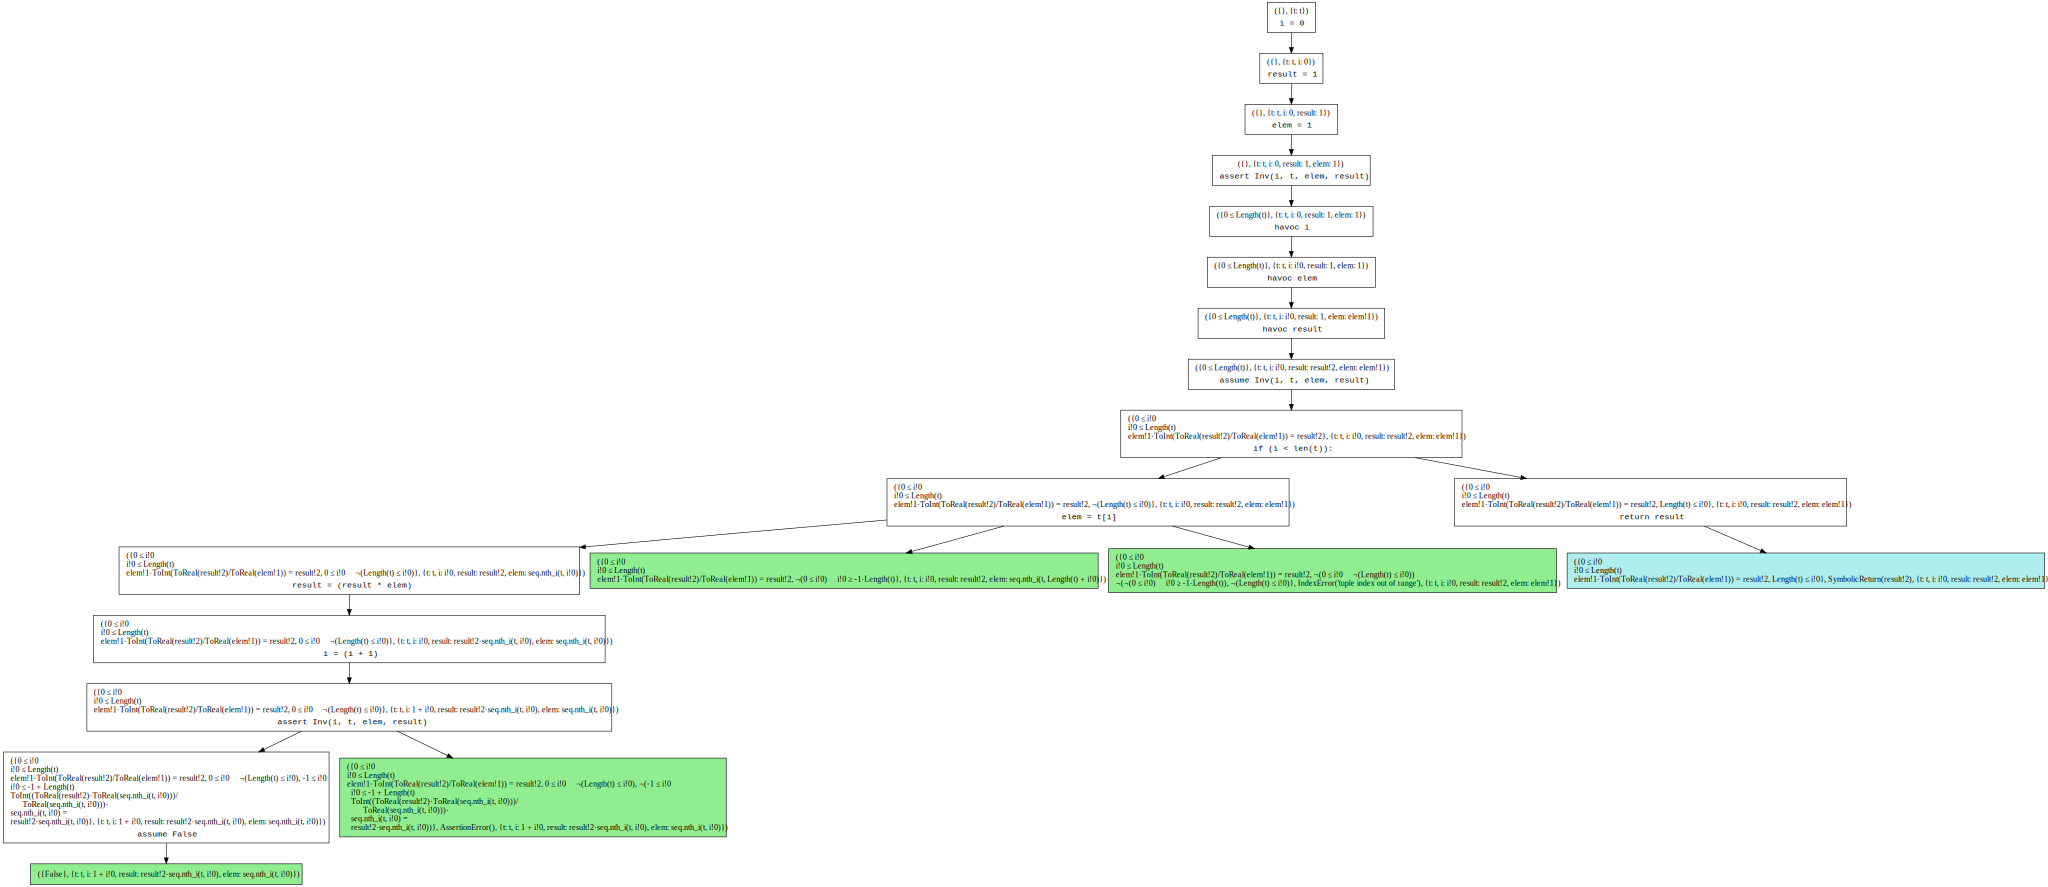

In [12]:
kv = z3.Int("k")
invariant = (
    lambda iv, tv, elemv, resultv:
    z3.And(
        iv >= z3.IntVal(0),
        iv <= z3.Length(tv),
        z3.ToInt(z3.ToReal(resultv) / z3.ToReal(elemv)) * elemv == resultv
        # resultv % elemv == z3.IntVal(0)
    ))

interpreter = SymbolicInterpreter(predicates={
    "Inv": ((z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.IntSort(), z3.IntSort()), z3.BoolSort(), invariant),
    "len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)
})

t = Variable("t", TUPLE_TYPE)
environment = SymbolicEnvironment().set(t, t.to_z3())

result = interpreter.execute(program_with_invariants_ast, environment)
display_set(result)

Since there are no red nodes in the SET, all invariant checks were passed, and we also did not miss any other exceptional cases! Let us check what happens if we *add* `elem` to `result` instead of computing the product:

In [13]:
faulty_program_with_invariants = """
i = 0
result = 1
elem = 1 

assert Inv(i, t, elem, result)

havoc i
havoc elem
havoc result
assume Inv(i, t, elem, result)

if i < len(t):
    elem = t[i]
    result = result + elem  # <-- "+"" instead of *
    i = i + 1
    assert Inv(i, t, elem, result)
    assume False

return result
"""

faulty_program_with_invariants_ast = parse(faulty_program_with_invariants)
display_program(faulty_program_with_invariants_ast.code)

```python
i = 0
result = 1
elem = 1
assert Inv(i, t, elem, result)
havoc i
havoc elem
havoc result
assume Inv(i, t, elem, result)
if (i < len(t)):
    elem = t[i]
    result = (result + elem)
    i = (i + 1)
    assert Inv(i, t, elem, result)
    assume False
return result
```

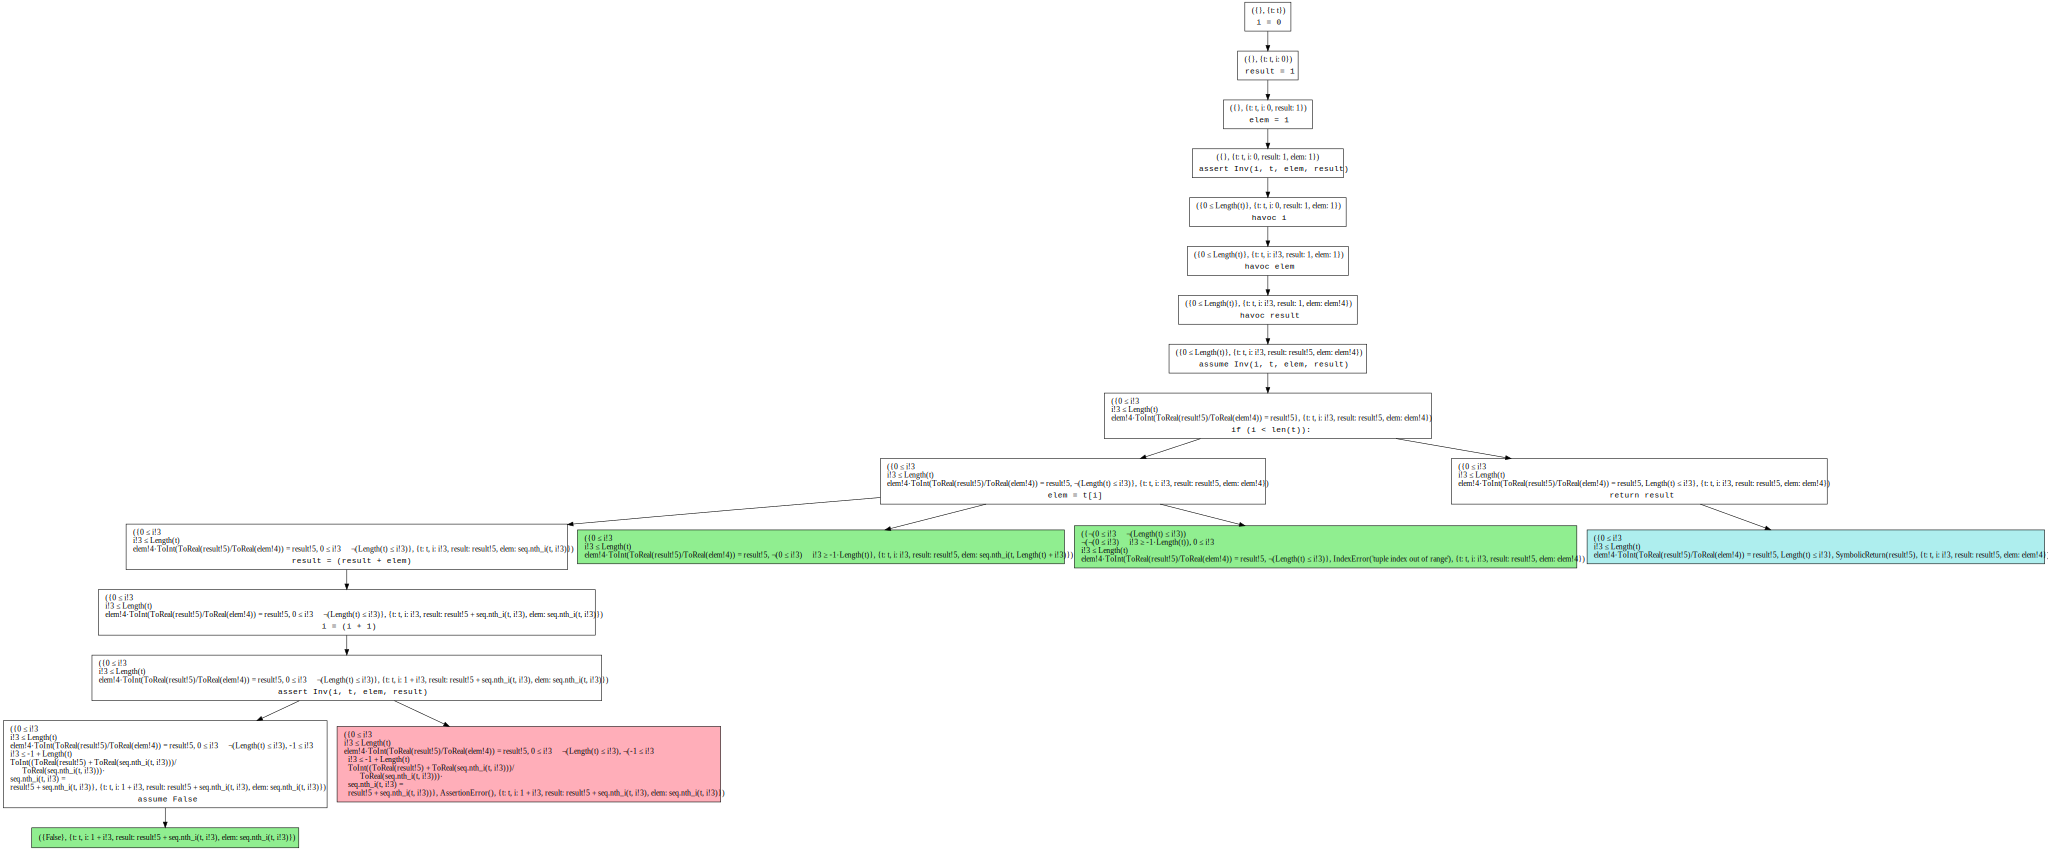

In [14]:
t = Variable("t", TUPLE_TYPE)
environment = SymbolicEnvironment().set(t, t.to_z3())

result = interpreter.execute(faulty_program_with_invariants_ast, environment)
display_set(result)

Now, there is a red node with an `AssertionError`: As expected, our buggy program mutant does not satisfy the loop invariant.

Next, we have a look at a slightly more complex example: A program *filtering* tuple values, retaining only the positive ones.

In [15]:
def filter_nonnegative(t: tuple) -> tuple:
    i = 0
    result = ()

    while i < len(t):
        if t[i] >= 0:
            result = result + (t[i], )

        i = i + 1

    return result

In [16]:
filter_nonnegative((3, 17, -4, 0, 5, -321))

(3, 17, 0, 5)

We transform the body of the `filter_nonnegative` function according to our "loop invariants with program transformation" approach:

In [17]:
filter_program_with_invariants = """
i = 0
result = () 

assert Inv(i, t, result)

havoc i
havoc result
assume Inv(i, t, result)

if i < len(t):
    if t[i] >= 0:
        result = result + (t[i], )
    i = i + 1
    assert Inv(i, t, result)
    assume False

return result 
"""

filter_program_with_invariants_ast = parse(filter_program_with_invariants)
display_program(filter_program_with_invariants_ast.code)

```python
i = 0
result = ()
assert Inv(i, t, result)
havoc i
havoc result
assume Inv(i, t, result)
if (i < len(t)):
    if (t[i] >= 0):
        result = (result + (t[i]))
    i = (i + 1)
    assert Inv(i, t, result)
    assume False
return result
```

The invariant maintained by this program is

1. `i` stays between 0 and the size of `t`
2. the size of `result` does not exceed the size of `iv`
3. all nonnegative elements of `t` up to (exclusively) index `i` are contained in `result`

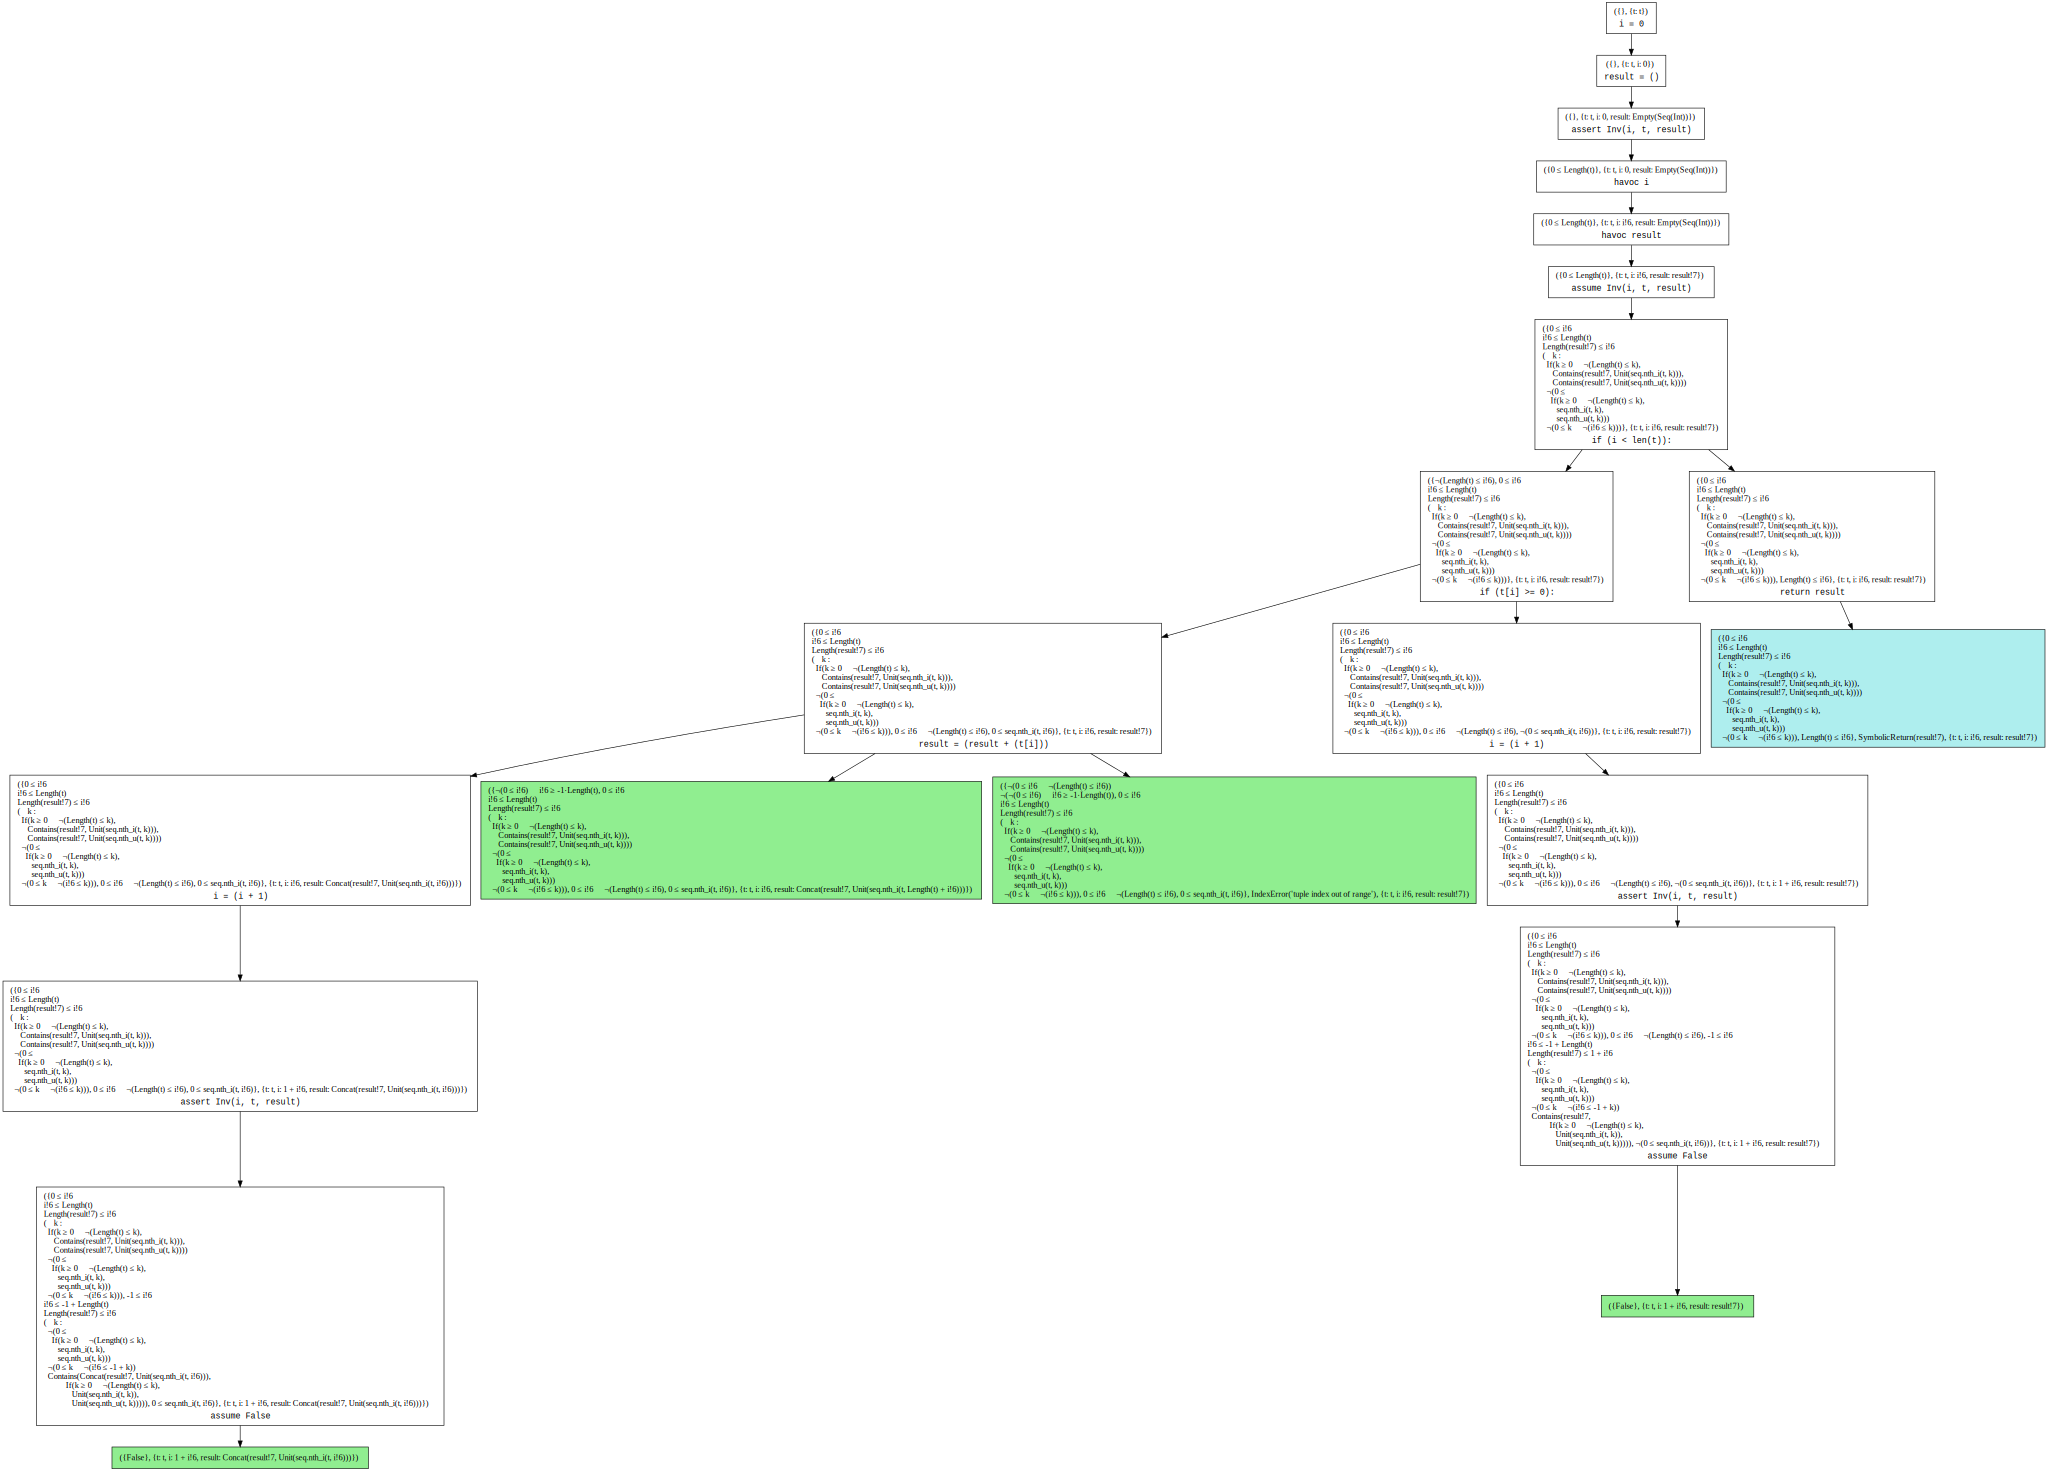

In [18]:
kv = z3.Int("k")
invariant = lambda iv, tv, resultv: \
    z3.And(
        iv >= z3.IntVal(0),
        iv <= z3.Length(tv),
        z3.Length(resultv) <= iv,
        z3.ForAll(
            [kv],
            z3.Implies(
                z3.And(z3.IntVal(0) <= kv, kv < iv),
                z3.Or(
                    tv[kv] < z3.IntVal(0),
                    z3.Contains(resultv, z3.Unit(tv[kv])))
            )
        )
    )

interpreter = SymbolicInterpreter(predicates={
    "Inv": ((z3.IntSort(), z3.SeqSort(z3.IntSort()), z3.IntSort()), z3.BoolSort(), invariant),
    "len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)
})

t = Variable("t", TUPLE_TYPE)
environment = SymbolicEnvironment().set(t, t.to_z3())

result = interpreter.execute(filter_program_with_invariants_ast, environment)
display_set(result)

Note that the invariant occurs in the path constraint of the blue SET node (the "use case"). For any code following the loop, we can (and have to) therefore rely on the information encoded in the loop invariant when accessing values changed by the loop: The loop invariant is an *abstraction* of the loop's behavior. In {ref}`applications:proving`, we will have a look at the role of loop invariants in *program proving*. Reasonable loop invariants should at least exclude non-feasible exceptions raised in the code following the loop (e.g., by limiting the range of variables used for indexing tuples). To show stronger properties (e.g., functional postconditions), we also have to come up with stronger loop invariants.

For a final example, we return to the linear search program:

In [19]:
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
            
        i = i + 1
    else:
        return -1
    
    return i

Applying the code transformation as before yields (we only show the function's body):

```python
i = 0

assert Inv(i, needle, haystack)

havoc i
assume Inv(i, needle, haystack)

if i < len(haystack):
    if haystack[i] == needle:
        break
            
    i = i + 1
    assert Inv(i, needle, haystack)
    assume False
else:
    return -1

return i 
```

Obviously, we missed something: What do we do about the `break` statement, which now appears outside any `while` statement? To preserve its semantics, we have to change the program such that no loop code is executed after hitting the `break`. For this simple example, this is not too difficult:

```python
i = 0

assert Inv(i, needle, haystack)

havoc i
assume Inv(i, needle, haystack)

if i < len(haystack):
    if haystack[i] == needle:
        pass  # <-- formerly break
    else:
        i = i + 1
        assert Inv(i, needle, haystack)
        assume False
else:
    return -1

return i 
```

It suffices to replace the `break` by a `pass` and to embed the remaining loop code inside the `else` branch of the `if`. Turning this idea into an automated, general transformation still remains a major challenge with potentially many special cases to consider.

## Loop Scopes

An alternative approach which does not require any program transformation of loop bodies was proposed in {cite}`steinhoefel.wasser-17`. This work introduces so-called *loop scope statements*, which are similar in spirit to the method frames described in {ref}`techniques:transparent_function_execution`. The idea is that we do not need to transform, for example, the `break` statement above. Instead, a `break` statement may legally occur within a loop scope, which "swallows" it and completes normally.

The original loop scope statements from {cite}`steinhoefel.wasser-17` are statements of the form

```python
loop-scope(x):
    body
```

where `x` is the boolean *index variable* of the loop scope and `body` its body. Their intuitive semantics is that `x` is set to `False` if, and only if, `body` completes abruptly because of a `continue` statement, and is set to `True` otherwise. That is, `x` indicates if the loop has been *exited*. Loop scopes were implemented for the rule-based symbolic execution engine KeY[^key]. There, the value of `x` is then used in an updated postcondition to distinguish whether the loop invariant or the original postcondition has to be shown. It turns out that in our symbolic minipy interpreter, the index `x` is not needed, since we can simply "catch" the abrupt completion behavior of `body` and proceed accordingly.

In {cite}`steinhoefel-20*1`, loop scopes are given a precise, non-mechanized semantics. We adapt this definition to minipy, which involves both changes to the syntax *and* semantics of loop scopes. Syntactically, we drop the loop scope index `x`, and instead require a boolean expression as argument: The loop invariant. The syntax of minipy loop scopes is

```python
loop-scope(inv=expr):
    body
```

where `expr` is a boolean expression. We also change the semantics; most notably, we check the invariant if the `body` completes due to a `continue` statement, and either terminate the execution if the invariant is satisfied (cf. the addition of `False` to the path constraint in case of the transformation-based approach) or raise an `AssertionError`. Subsequently, we provide a more precise description.

A loop scope statement is executed by first executing the body `body`. Then there is a choice:

- If execution of `body` completes normally, the behavior of the loop scope statement is undefined.
- If execution of `body` completes abruptly because of a `break`, the loop scope statement completes normally.
- If execution of `body` completes abruptly because of a `continue`, there is a choice:
  + If `expr` evaluates to `True`, the execution (of the whole program) completes normally.
  + If `expr` evaluates to `False`, the loop scopes statement completes abruptly because of an `AssertionError`.
- If execution of `body` completes abruptly for any other reason, the loop scope statement completes abruptly for the same reason.

This facilitates a different kind of program transformation for loop invariant-based symbolic execution of loops which leaves loop *bodies* fully intact. A `while` loop with guard `guard`, body `body`, assigned locations `x_1` to `x_n` and invariant expression `Inv` is transformed to

```python
assert Inv

havoc x_1
# ...
havoc x_n
assume Inv

loop-scope(inv=Inv):    
    if guard:
        body
        continue
    else:
        break
```

If the loop has an `else` branch with body `else_body`, we retain this branch, adding a trailing `else` statement. We obtain

```python
assert Inv

havoc x_1
# ...
havoc x_n
assume Inv

loop-scope(inv=Inv):    
    if guard:
        body
        continue
    else:
        else_body
        break
```

Observe that it is not possible for the body of the loop scope to complete normally. If the original `body` completes normally, the newly added `continue` statement is reached and the loop invariant checked. If the guard evaluates to `False`, we hit the added `break` statement, leading to the classic *use case* of loop invariant reasoning.

### Grammar, Parser, and Mechanized Semantics 

Let us implement loop scopes for minipy. First, as usual, we extend the grammar, add AST node classes and extend the ASTConverter.

In [20]:
MINIPY_GRAMMAR["<compound_stmt>"].insert(0, "<loop_scope>")
MINIPY_GRAMMAR["<loop_scope>"] = ["loop-scope(inv=<expression>):<block>"]

In [21]:
class LoopScope(ASTNode):
    def __init__(self, inv: Expression, block: Block):
        super().__init__(f"loop-scope(inv={inv.code}):\n{indent(block.code, '    ')}")
        self.inv = inv
        self.block = block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(LoopScope(self.inv.transform(transformer), self.block.transform(transformer)))

In [22]:
class ASTConverter(ASTConverter):
    def __init__(self):
        super().__init__()
        self.stmt_interpretations["<loop_scope>"] = self.transform_loop_scope_stmt
        
    def transform_compound_stmt(self, stmt: ParseTree) -> ASTNode:
        return self.transform_simple_redirect(
            stmt, ("<loop_scope>", "<method_frame>", "<function_def>", "<try_stmt>", "<if_stmt>", "<while_stmt>"))
        
    def transform_loop_scope_stmt(self, stmt: ParseTree) -> LoopScope:
        m_res = match(("loop-scope(inv=", "<expression>", "):", "<block>"), stmt)
        assert m_res is not None

        return LoopScope(self.transform_expression(m_res[1]), self.transform_block(m_res[-1]))

In [23]:
def parse(inp: str) -> 'ASTNode':
    inp = strip_comments_and_whitespace(inp)
    tree = PythonPEGParser(MINIPY_GRAMMAR).parse(inp)[0]
    return ASTConverter().transform_top(tree)

In [24]:
find_loop_scopes = """
i = 0

assert Inv(i, needle, haystack)

havoc i
assume Inv(i, needle, haystack)

loop-scope(inv=Inv(i, needle, haystack)):
    if i < len(haystack):
        if haystack[i] == needle:
            break
        
        i = i + 1
        continue
    else:
        return -1
        break

return i 
"""

find_loop_scopes_ast = parse(find_loop_scopes)
display_program(find_loop_scopes_ast.code)

```python
i = 0
assert Inv(i, needle, haystack)
havoc i
assume Inv(i, needle, haystack)
loop-scope(inv=Inv(i, needle, haystack)):
    if (i < len(haystack)):
        if (haystack[i] == needle):
            break
        i = (i + 1)
        continue
    else:
        return -1
        break
return i
```

As we did for method frames in {ref}`techniques:transparent_function_execution`, we can mechanize the semantics of loop scopes by implementing their behavior in the concrete minipy interpreter.

In [25]:
class Interpreter(Interpreter):
    def __init__(self):
        super().__init__()
        self.stmt_interpretations[LoopScope] = self.execute_loop_scope
        
    def execute_loop_scope(self, stmt: LoopScope, environment: Environment) -> None:
        try:
            self.execute(stmt.block, environment)
            assert False
        except Exception as exc:
            if isinstance(exc, Break):
                return
            elif isinstance(exc, Continue):
                if self.evaluate(stmt.inv, environment):
                    raise Halt()
                else:
                    raise AssertionError(f"Loop scope invariant {stmt.inv.code} not satisfied.")
            else:
                raise exc

For experimenting with this implementation, we use a simple loop iterating over a tuple and performing special actions for the magic values 17 and 42:

```python
while i < len(t):
    if i == 17:
        break
    if i == 42:
        return i + 1

    i = i + 1
```

Assuming the invariant `inv >= 0 and i <= len(t)`, transforming loop as explained above for invariant-based symbolic execution with loop scopes yields the following loop scope statement:

In [26]:
loop_scope_program = """
loop-scope(inv=i >= 0 and i <= len(t)):
    if i < len(t):
        if i == 17:
            break
        if i == 42:
            return i + 1
            
        i = i + 1
        continue
    else:
        break
"""

loop_scope_program_ast = parse(loop_scope_program)
display_program(loop_scope_program_ast.code)

```python
loop-scope(inv=((i >= 0) and (i <= len(t)))):
    if (i < len(t)):
        if (i == 17):
            break
        if (i == 42):
            return (i + 1)
        i = (i + 1)
        continue
    else:
        break
```

If the loop is entered and the `continue` statement reached, the invariant is verified. If this succeeds, the execution completes due to a raised `Halt` exception (which is a special exception type signaling abrupt completion of the execution for a reason other than an error).

In [27]:
i = Variable("i", INT_TYPE)
t = Variable("t", TUPLE_TYPE)

interpreter = Interpreter()

environment = Environment()
environment[i] = 3
environment[t] = (1, 2, 3, 4, 5)

try:
    interpreter.execute(loop_scope_program_ast, environment)
except Halt:
    print(f"Invariant satisfied (Halt raised). i={environment[i]}")

Invariant satisfied (Halt raised). i=4


If the value of index `i` exceeds the tuple size, the loop body is not executed and the `break` statement hit instead. The value of `i` is not changed.

In [28]:
environment = Environment()
environment[i] = 6  # Out of bounds; loop body not entered
environment[t] = (1, 2, 3, 4, 5)

interpreter.execute(loop_scope_program_ast, environment)
print(f"Program completed normally. i={environment[i]}")

Program completed normally. i=6


The magic value 17 induces an abrupt completion of the body due to a `break` statement. The loop scope completes normally, `i` remains unchanged.

In [29]:
environment = Environment()
environment[i] = 17  # Magic value
environment[t] = tuple([i for i in range(50)])

interpreter.execute(loop_scope_program_ast, environment)
print(f"Program completed normally. i={environment[i]}")

Program completed normally. i=17


For the magic value 42, a `return` is executed.

In [30]:
environment = Environment()
environment[i] = 42  # Magic value
environment[t] = tuple([i for i in range(50)])

try:
    interpreter.execute(loop_scope_program_ast, environment)
except Return as ret:
    print(f"Program completed because of a return of {ret.value}. i={environment[i]}")

Program completed because of a return of 43. i=42


Since `i` is not initialized before the loop and the loop guard only checks if `i` is too *big*, we can assign it a negative initial value leading to a violation of the loop invariant.

In [31]:
environment = Environment()
environment[i] = -3  # out of bounds, but still enters loop body
environment[t] = (1, 2, 3)

try:
    interpreter.execute(loop_scope_program_ast, environment)
except AssertionError:
    print(f"Loop invariant not satisfied. i={environment[i]}")

Loop invariant not satisfied. i=-2


### Symbolic Execution of Loop Scopes

Extending the symbolic interpreter with loop scope support is not too difficult since we can copy the code for the most difficult part, the checking of the invariant in the case of a completion due to a `continue` statement, from the method handling `assert` statements. 

In [32]:
class SymbolicInterpreter(SymbolicInterpreter):
    def __init__(self,
                 loop_unrolling_threshold: Optional[int] = None,
                 predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__(loop_unrolling_threshold, predicates)
        self.stmt_interpretations[LoopScope] = self.execute_loop_scope
        
    def execute_loop_scope(self, stmt: LoopScope, environment: SymbolicEnvironment) -> SET:
        tree = self.execute(stmt.block, environment)
        result = (SETNode(environment, stmt.code), [tree])

        for leaf in get_leaves(tree):
            leaf_node, _ = leaf
            environment = leaf_node.environment
            exc = leaf_node.environment.abrupt_completion

            assert exc is not None

            if isinstance(exc, Break):
                result = replace_in_tree(
                    result, leaf, (SETNode(leaf_node.environment.set_abrupt_completion(None)), []))
            elif isinstance(exc, Continue):
                eval_inv_result = self.evaluate(stmt.inv, environment)
                children = leaf[1]

                for value, constraint in eval_inv_result:
                    if isinstance(value, Exception):
                        exc_node = (SETNode(environment
                                            .add_constraint(constraint)
                                            .set_abrupt_completion(value), ''), [])
                        if not exc_node[0].environment.unsatisfiable():
                            children.append(exc_node)
                    else:
                        assert type(value) is z3.BoolRef
                        sat_node = (SETNode(environment
                                            .add_constraint(constraint)
                                            .add_constraint(value)
                                            .set_abrupt_completion(Halt()), ''), [])
                        if not sat_node[0].environment.unsatisfiable():
                            children.append(sat_node)

                        viol_node = (SETNode(environment
                                             .add_constraint(constraint)
                                             .add_constraint(z3.Not(value))
                                             .set_abrupt_completion(AssertionError()), ''), [])
                        if not viol_node[0].environment.unsatisfiable():
                            children.append(viol_node)

        return result

As an example for demonstrating the result of this implementation, we take our linear search program. Its loop invariant is "i stays within 0 and the size of haystack (inclusively), and we did not find `needle` at all previous indexes".

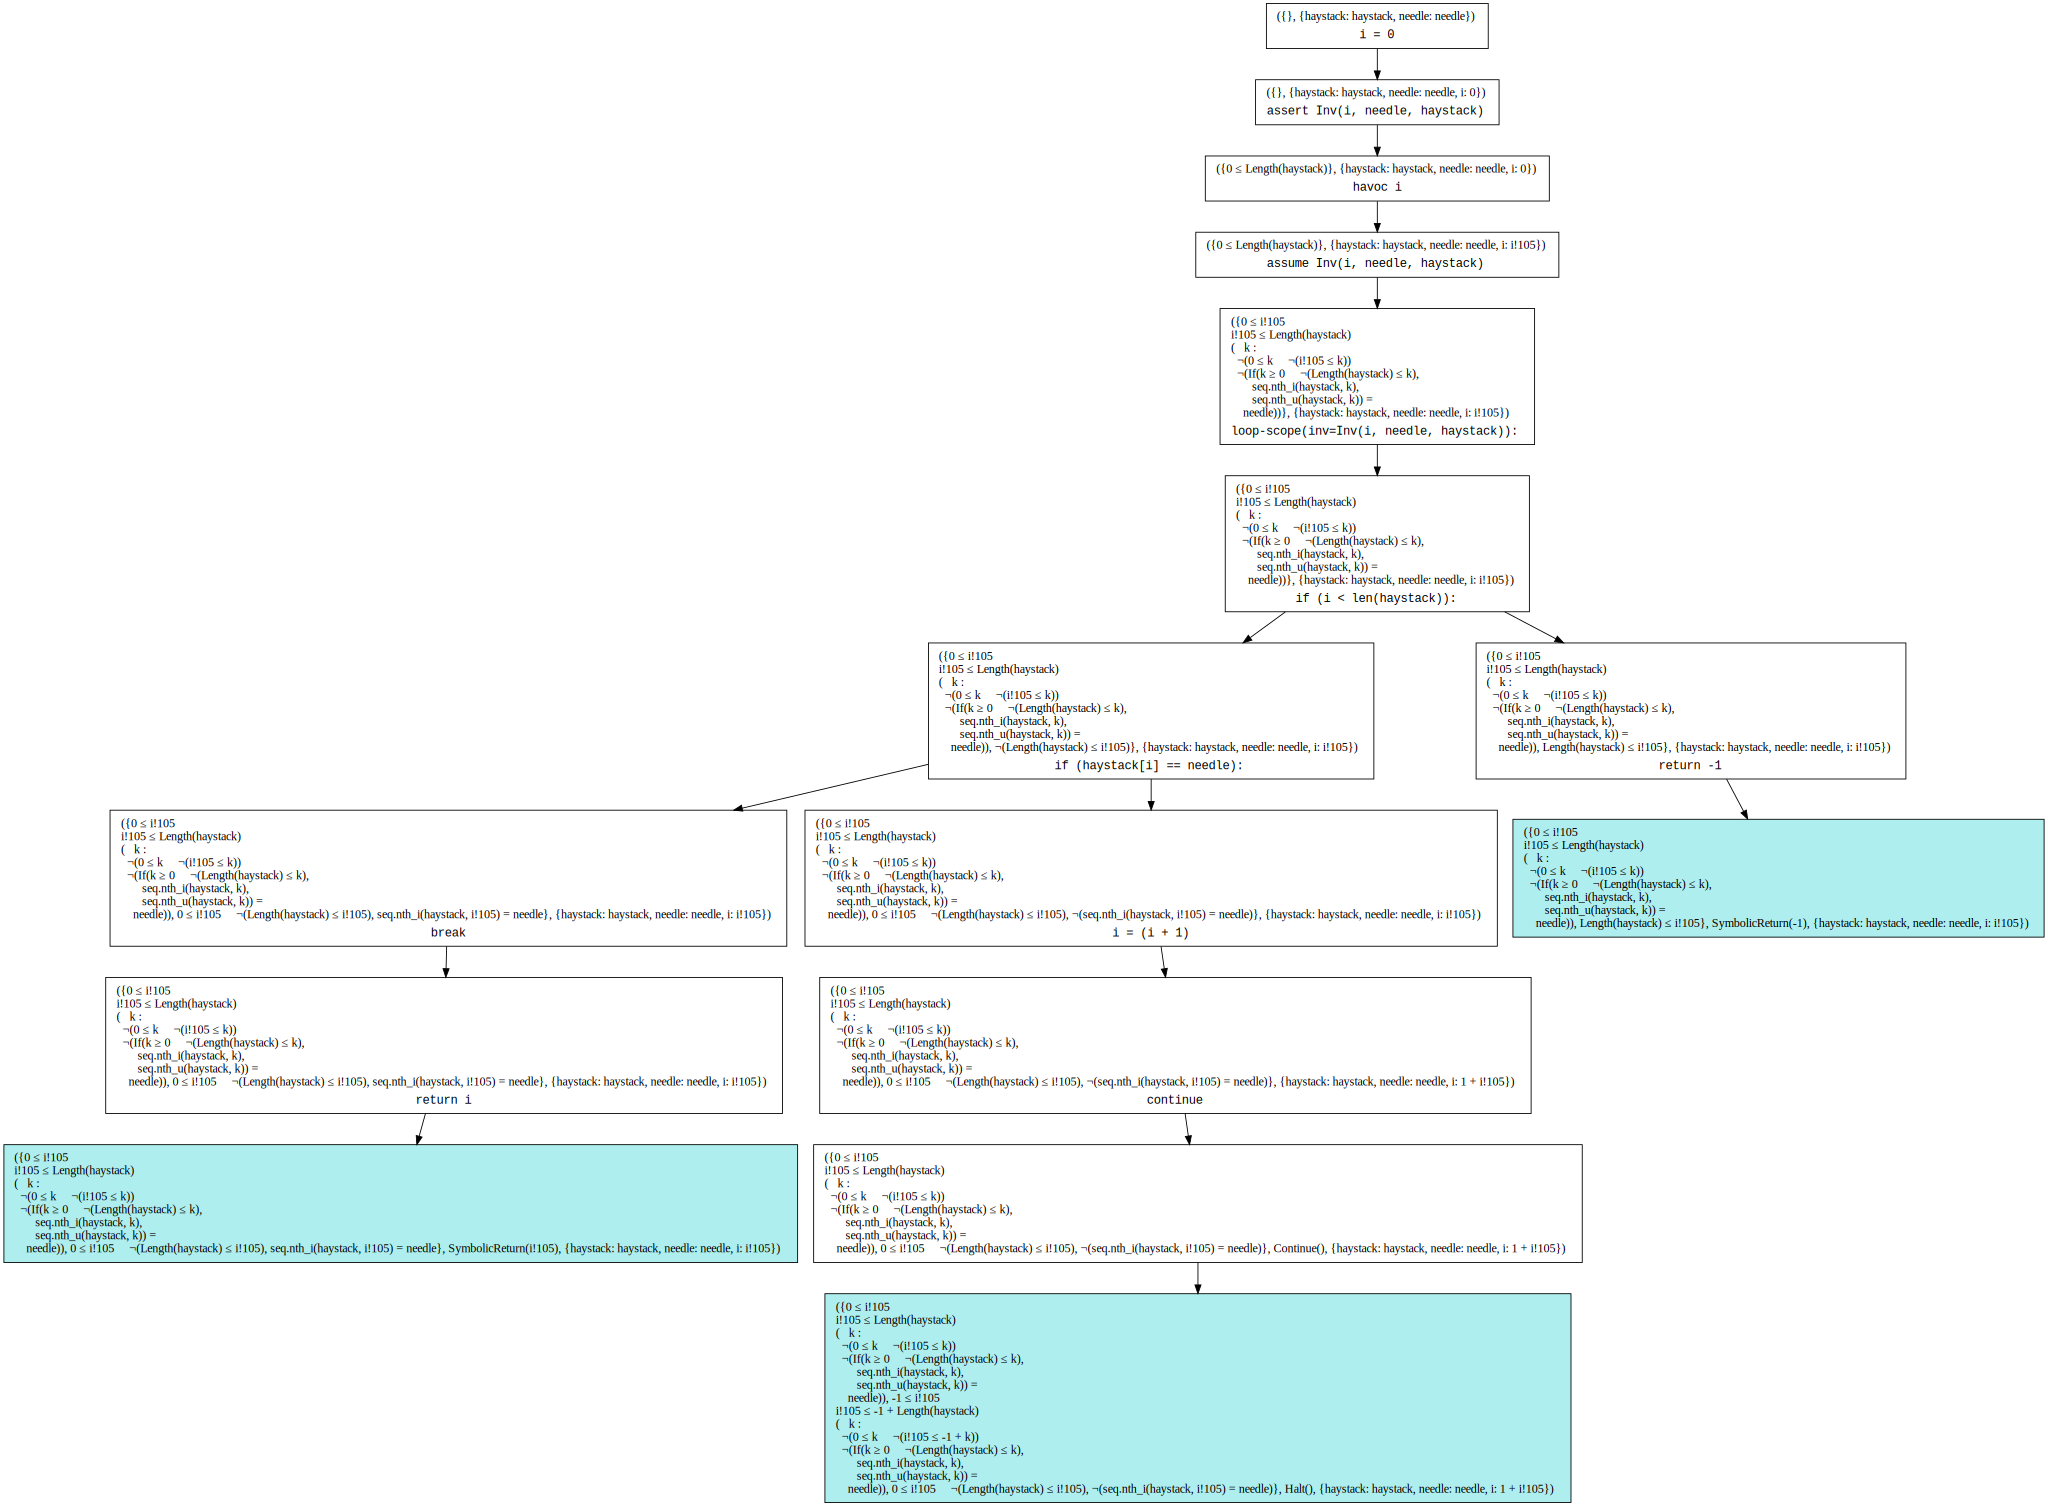

In [33]:
kv = z3.Int("k")
invariant = lambda iv, needlev, haystackv: \
    z3.And(
        iv >= z3.IntVal(0),
        iv <= z3.Length(haystackv),
        z3.ForAll(
            [kv],
            z3.Implies(
                z3.And(z3.IntVal(0) <= kv, kv < iv),
                z3.Not(haystackv[kv] == needlev)
            )
        )
    )

interpreter = SymbolicInterpreter(predicates={
    "Inv": ((z3.IntSort(), z3.IntSort(), z3.SeqSort(z3.IntSort())), z3.BoolSort(), invariant),
    "len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)
})

needle = Variable("needle", INT_TYPE)
haystack = Variable("haystack", TUPLE_TYPE)
environment = SymbolicEnvironment().set(haystack, haystack.to_z3()).set(needle, needle.to_z3())

result = interpreter.execute(find_loop_scopes_ast, environment)
display_set(result)

What happens if we add a small bug into our implementation? Assume we typed `i = i + i` instead `i = i + 1` (which is not entirely impossible):

In [34]:
find_loop_scopes_buggy = """
i = 0

assert Inv(i, needle, haystack)

havoc i
assume Inv(i, needle, haystack)

loop-scope(inv=Inv(i, needle, haystack)):
    if i < len(haystack):
        if haystack[i] == needle:
            break

        i = i + i
        continue
    else:
        return -1
        break

return i 
"""

find_loop_scopes_buggy_ast = parse(find_loop_scopes_buggy)
display_program(find_loop_scopes_buggy_ast.code)

```python
i = 0
assert Inv(i, needle, haystack)
havoc i
assume Inv(i, needle, haystack)
loop-scope(inv=Inv(i, needle, haystack)):
    if (i < len(haystack)):
        if (haystack[i] == needle):
            break
        i = (i + i)
        continue
    else:
        return -1
        break
return i
```

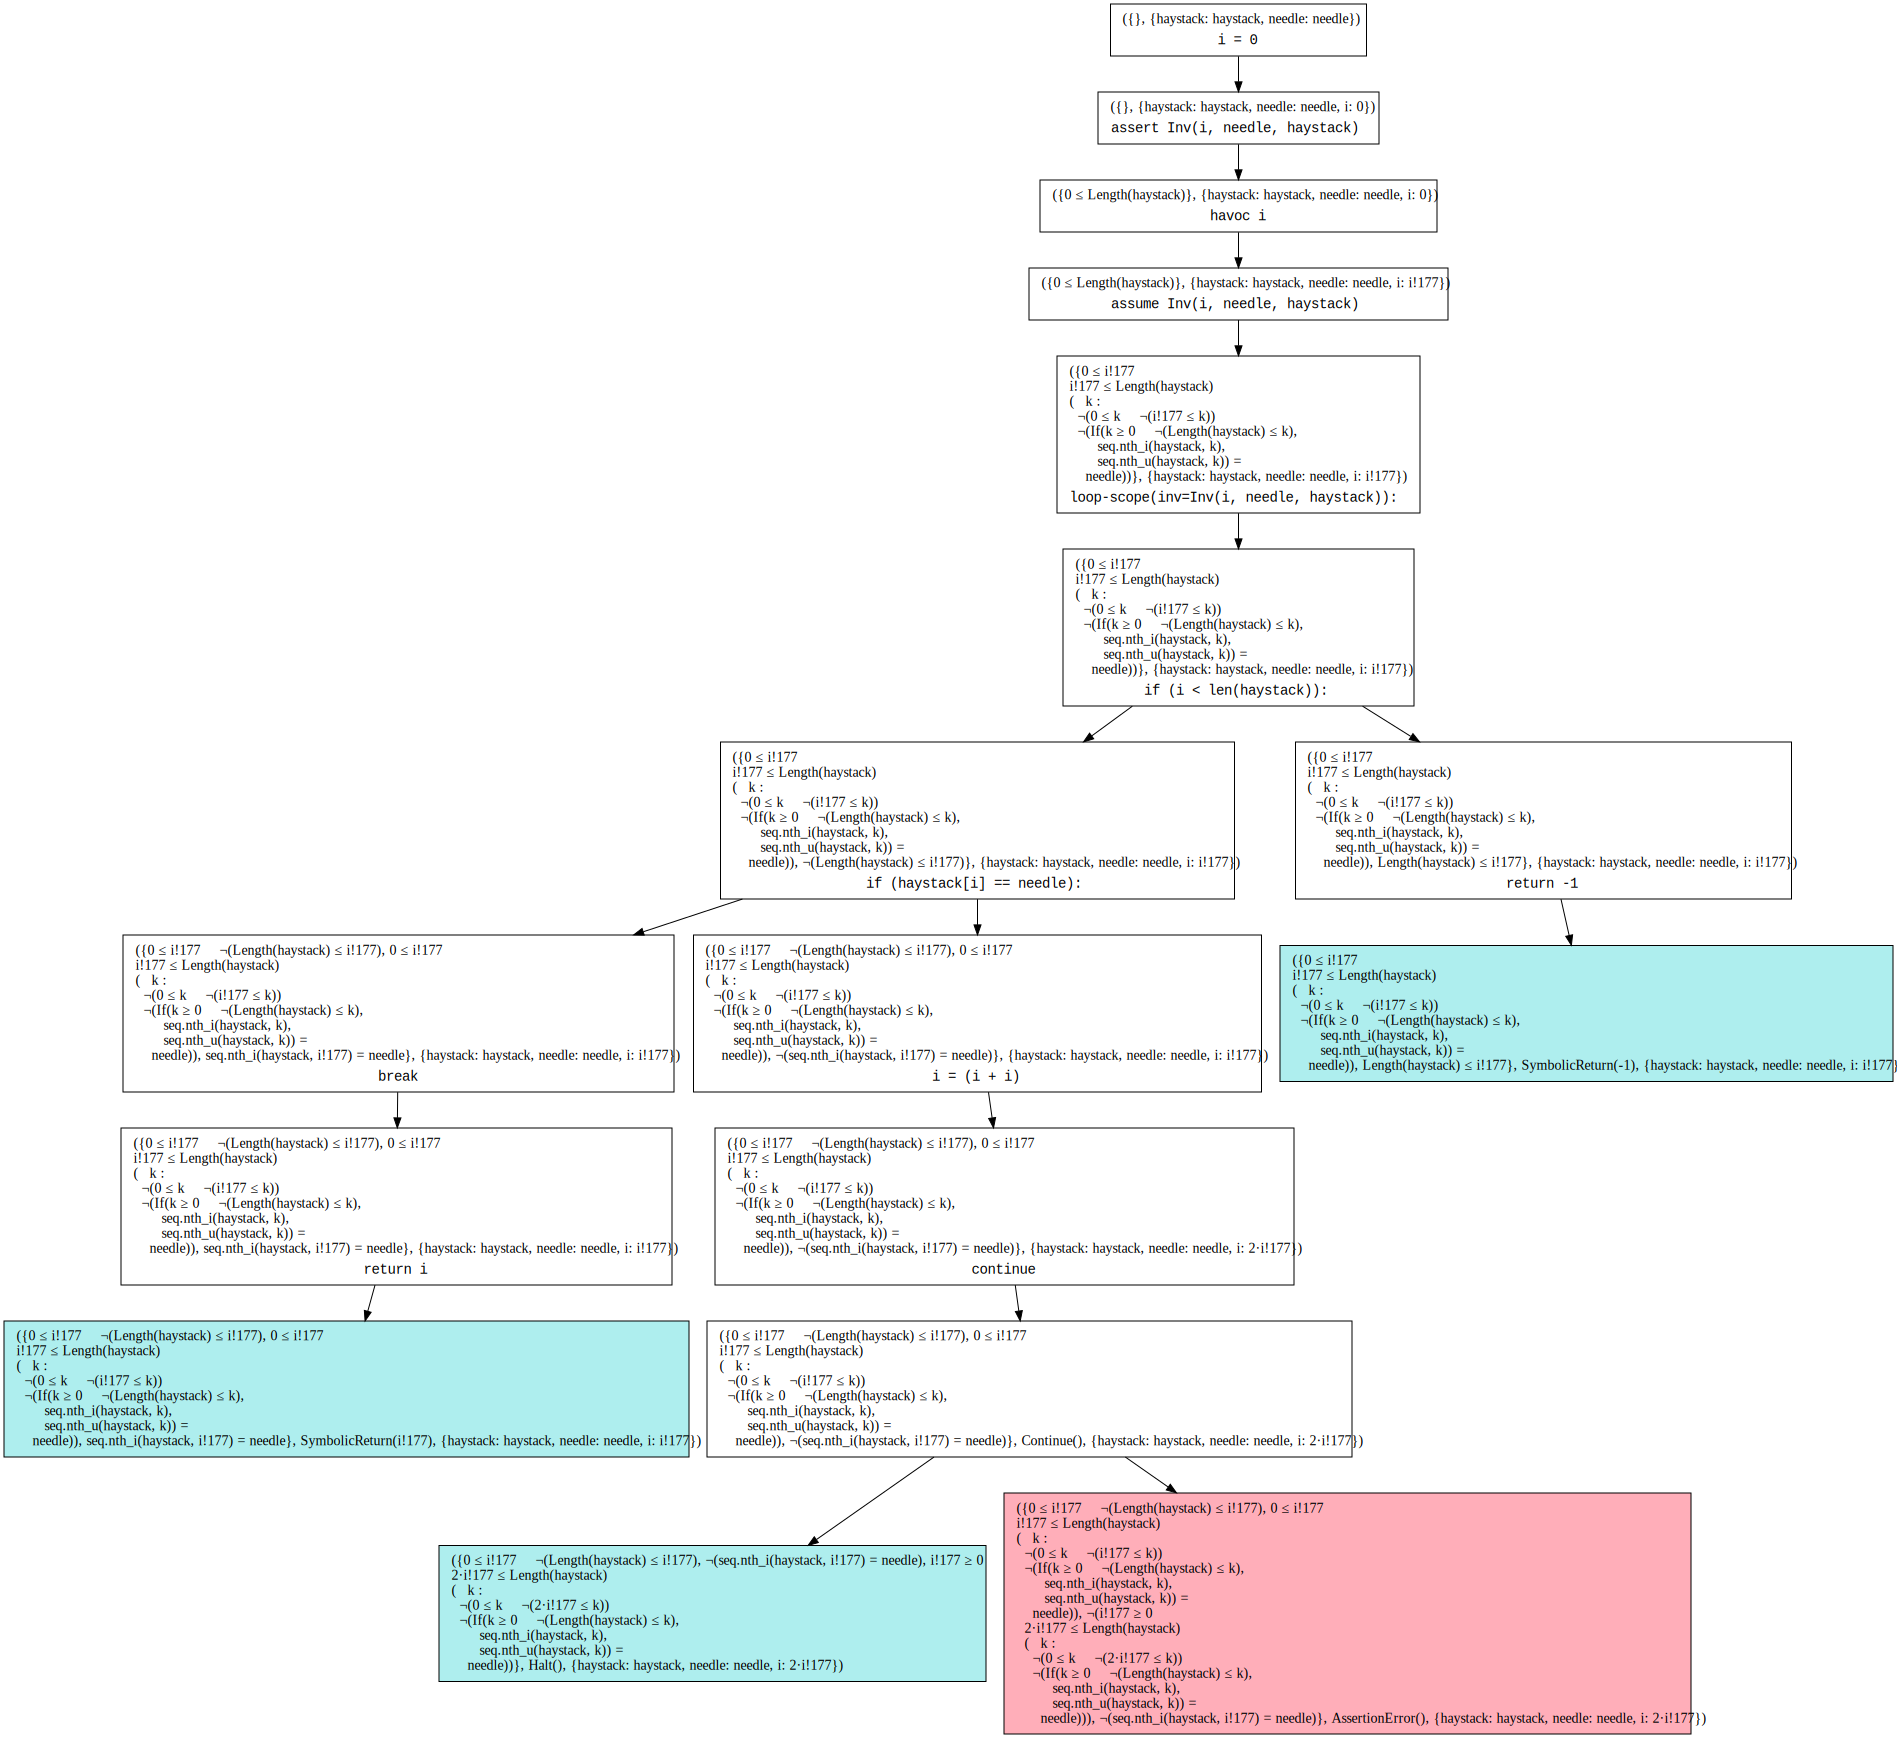

In [35]:
result = interpreter.execute(find_loop_scopes_buggy_ast, environment)
display_set(result)

Now, we get an `AssertionError` node after the SET node for the `continue` statement, since the invariant is not preserved by the code.

The only missing puzzle piece is an automatic transformation from loops into loop scopes. Since we do not have to perform transformations inside loop bodies, this is easy to implement. First, however, we define another visitor class to retrieve assigned loop locations for the introduction of the `havoc` statements.

In [46]:
class AssignedVariablesVisitor:
    def __init__(self):
        self.result: Set[str] = set()

    def __call__(self, *args, **kwargs):
        assert len(args) == 1
        assert not kwargs
        assert isinstance(args[0], ASTNode)
        node: ASTNode = args[0]

        if isinstance(node, Assignment):
            self.result.add(node.lhs)

        return node

    @staticmethod
    def get_assigned_variables(node: ASTNode) -> Set[str]:
        visitor = AssignedVariablesVisitor()
        node.transform(visitor)
        return visitor.result

The `LoopScopeTransformer` class itself is straightforward. It requires a mapping from loop statements to invariant expressions which we insert into the loop scope statements.

In [52]:
class LoopScopeTransformer:
    def __init__(self, invariants: Dict[WhileStmt, Expression]):
        self.invariants = invariants

    def __call__(self, *args, **kwargs):
        assert len(args) == 1
        assert not kwargs
        assert isinstance(args[0], ASTNode)
        node: ASTNode = args[0]

        if isinstance(node, WhileStmt):
            inv = self.invariants[node]
            assigned_vars = AssignedVariablesVisitor.get_assigned_variables(node)

            result_stmts: List[ASTNode] = [Assert(inv)]
            result_stmts.extend([Havoc(variable) for variable in assigned_vars])
            result_stmts.append(Assume(inv))

            body = IfStmt(
                node.guard,
                Block(node.body.stmts + [ContinueStmt()]),
                Block([] if node.else_block is None else node.else_block.stmts + [BreakStmt()])
            )

            result_stmts.append(LoopScope(inv, Block([body])))

            return Stmts(result_stmts)

        return node

We transform the body of our linear search program:

In [53]:
find_program = """
i = 0
while i < len(haystack):
    if haystack[i] == needle:
        break

    i = i + 1
else:
    return -1

return i
"""

find_program_ast = parse(find_program)
display_program(find_program_ast.code)

```python
i = 0
while (i < len(haystack)):
    if (haystack[i] == needle):
        break
    i = (i + 1)
else:
    return -1
return i
```

The transformation requires that we first extract the loop statement for assigning it its invariant.

In [54]:
loop_stmt = next(iter(
    FilterASTVisitor.filter(find_program_ast, lambda node: isinstance(node, WhileStmt))))
display_program(loop_stmt.code)

```python
while (i < len(haystack)):
    if (haystack[i] == needle):
        break
    i = (i + 1)
else:
    return -1
```

In [55]:
loop_scope_transformer = LoopScopeTransformer({loop_stmt: parse_expr("Inv(i, needle, haystack)")})
find_loop_scopes = find_program_ast.transform(loop_scope_transformer)
display_program(find_loop_scopes.code)

```python
i = 0
assert Inv(i, needle, haystack)
havoc i
assume Inv(i, needle, haystack)
loop-scope(inv=Inv(i, needle, haystack)):
    if (i < len(haystack)):
        if (haystack[i] == needle):
            break
        i = (i + 1)
        continue
    else:
        return -1
        break
return i
```

This looks as expected! As promised in {ref}`techniques:transparent_function_execution`, we can combine (chain) the transformers for loop scopes and method frames, such that the full version of the linear search program including the method call can be transformed and transparently executed symbolically:

In [56]:
find_program_with_func_decl = """
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
            
        i = i + 1
    else:
        return -1
    
    return i

result = find(needle, haystack)
"""

find_program_with_func_decl_ast = parse(find_program_with_func_decl)
display_program(find_program_with_func_decl_ast.code)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while (i < len(haystack)):
        if (haystack[i] == needle):
            break
        i = (i + 1)
    else:
        return -1
    return i
result = find(needle, haystack)
```

In [57]:
find_program_with_func_decl_loop_scopes = \
    find_program_with_func_decl_ast.transform(loop_scope_transformer)
display_program(find_program_with_func_decl_loop_scopes.code)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    assert Inv(i, needle, haystack)
    havoc i
    assume Inv(i, needle, haystack)
    loop-scope(inv=Inv(i, needle, haystack)):
        if (i < len(haystack)):
            if (haystack[i] == needle):
                break
            i = (i + 1)
            continue
        else:
            return -1
            break
    return i
result = find(needle, haystack)
```

In [58]:
method_frame_transformer = MethodFrameTransformer(find_program_with_func_decl_loop_scopes)
find_program_with_func_decl_loop_scopes_method_frames = \
    find_program_with_func_decl_loop_scopes.transform(method_frame_transformer)
display_program(find_program_with_func_decl_loop_scopes_method_frames.code)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    assert Inv(i, needle, haystack)
    havoc i
    assume Inv(i, needle, haystack)
    loop-scope(inv=Inv(i, needle, haystack)):
        if (i < len(haystack)):
            if (haystack[i] == needle):
                break
            i = (i + 1)
            continue
        else:
            return -1
            break
    return i
method-frame(result=var_0):
    needle = needle
    haystack = haystack
    i = 0
    assert Inv(i, needle, haystack)
    havoc i
    assume Inv(i, needle, haystack)
    loop-scope(inv=Inv(i, needle, haystack)):
        if (i < len(haystack)):
            if (haystack[i] == needle):
                break
            i = (i + 1)
            continue
        else:
            return -1
            break
    return i
result = var_0
```

Symbolically executing this code uses sound loop-invariant based loop abstraction thanks to loop scopes, and produces an SET including nodes for all intermediate execution steps thanks to method frames.

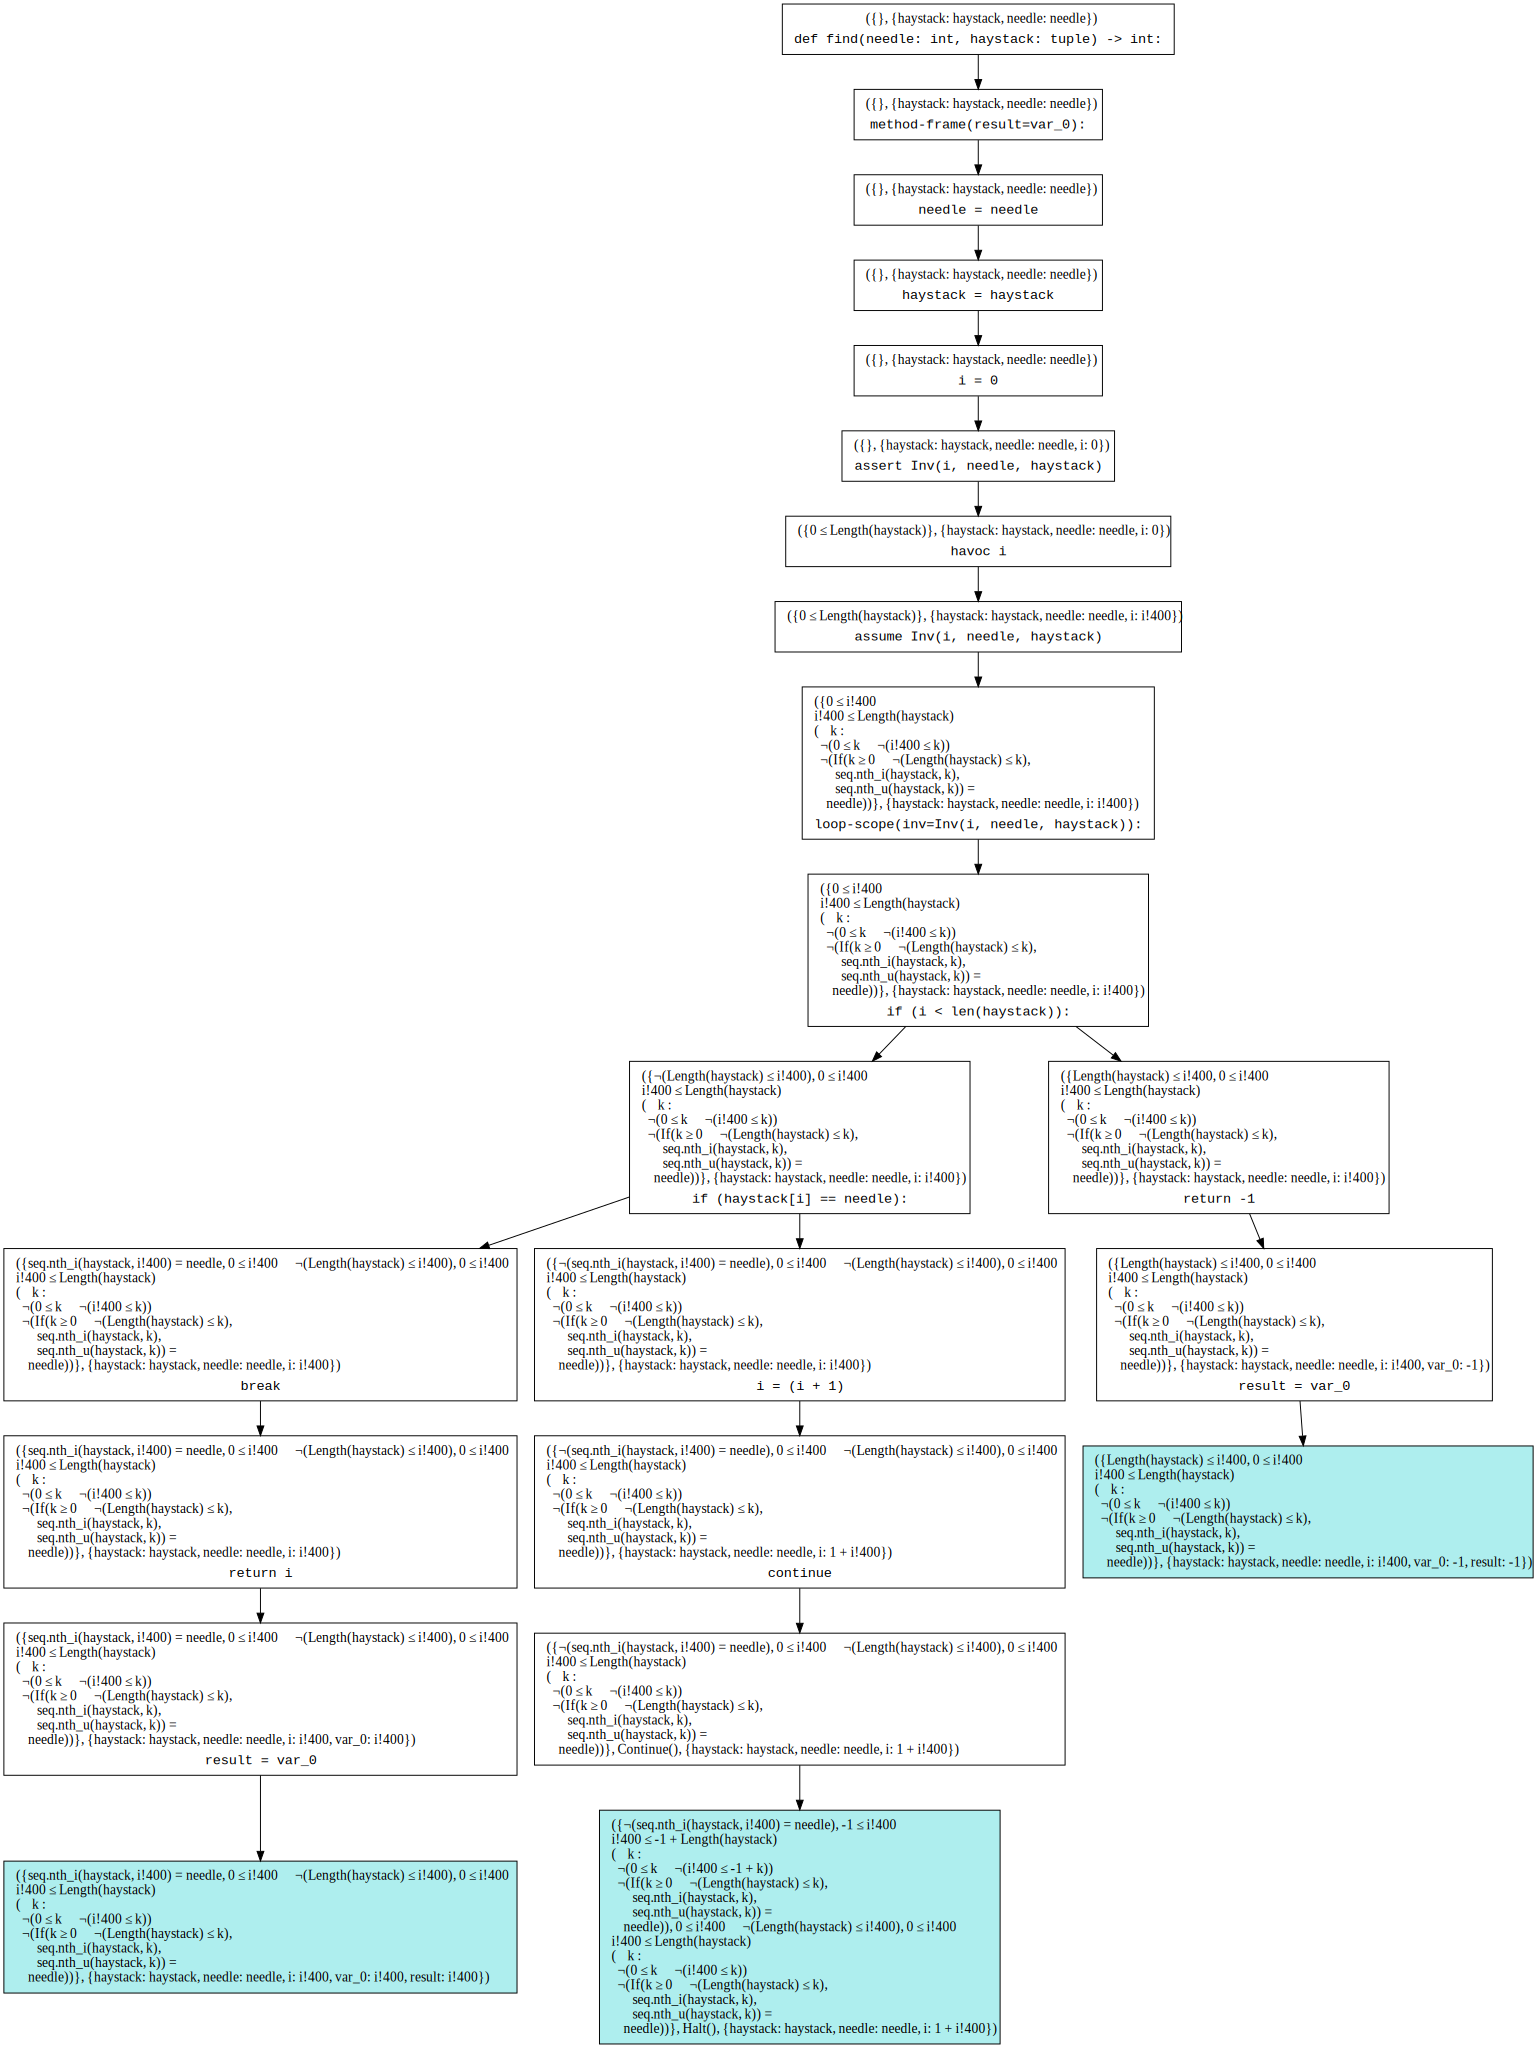

In [59]:
result = interpreter.execute(find_program_with_func_decl_loop_scopes_method_frames, environment)
display_set(result)

```{admonition} TODO
Final words, maybe descriptions of related approaches to loop invariant reasoning (loop invariant inference, abstract interpretation, mention that in dynamic SE, pruning/search strategies are used)
```

## References

```{bibliography}
:filter: docname in docnames
```

[^key]: https://www.key-project.org/